In [1]:
!pip install pandas scikit-learn optuna seaborn statsmodels scikit-optimize

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import optuna
import os
from include.utils import incrementar_dados_aleatorios_csv, categorizar_imc
from include.utils import prever_encargos_futuros, segmentacao_de_risco, analise_de_sensibilidade, otimizacao_de_recursos, planejamento_estrategico

In [3]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

**1. Engenharia de Recursos**

Novos recursos derivados dos dados existentes

In [4]:
# Obtém a largura do terminal - uso mais embaixo nos prints
terminal_width = os.get_terminal_size().columns

dados = pd.read_csv('../planilhas/2_dados_aleatorios_sobre_original.csv', encoding='latin-1')

# Aplicar a função para categorizar IMC e criar uma nova coluna 'Categoria_IMC'
dados['Categoria_IMC'] = dados['IMC'].apply(categorizar_imc)

print(dados)

      Idade     Gênero    IMC  Filhos Fumante    Região  Encargos  \
0      56.0   feminino  29.77     2.0     sim  sudoeste  31109.89   
1      46.0  masculino  25.86     1.0     não  nordeste  26650.70   
2      32.0  masculino  23.01     0.0     não  sudoeste  21459.04   
3      40.0   feminino  21.51     1.0     não  noroeste  29513.47   
4      35.0   feminino  30.34     0.0     sim  sudoeste  24925.01   
...     ...        ...    ...     ...     ...       ...       ...   
1998    NaN        NaN    NaN     NaN     NaN       NaN       NaN   
1999   36.0   feminino  31.84     3.0     sim  nordeste  24787.02   
2000   48.0  masculino  20.75     2.0     sim   sudeste  33152.85   
2001   74.0  masculino  19.99     2.0     não  nordeste  43367.61   
2002   46.0   feminino  29.59     1.0     não  noroeste  28691.27   

       Categoria_IMC  
0          Sobrepeso  
1          Sobrepeso  
2        Peso normal  
3        Peso normal  
4              Obeso  
...              ...  
1998  Valo

**2. Limpeza de Dados**

In [5]:
# Remover linhas com valores NaN
dados = dados.dropna()

# Substituir valores nulos por zero
dados['Filhos'] = dados['Filhos'].fillna(0)
dados['Filhos'] = dados['Filhos'].astype(int)
dados['Idade'] = dados['Idade'].fillna(0)
dados['Idade'] = dados['Idade'].astype(int)
dados['Encargos'] = dados['Encargos'].fillna(0)

dados['Gênero'] = dados['Gênero'].str.replace('nan', 'Não informado')

print(dados)

      Idade     Gênero    IMC  Filhos Fumante    Região  Encargos  \
0        56   feminino  29.77       2     sim  sudoeste  31109.89   
1        46  masculino  25.86       1     não  nordeste  26650.70   
2        32  masculino  23.01       0     não  sudoeste  21459.04   
3        40   feminino  21.51       1     não  noroeste  29513.47   
4        35   feminino  30.34       0     sim  sudoeste  24925.01   
...     ...        ...    ...     ...     ...       ...       ...   
1997     23   feminino  29.45       0     sim  noroeste  15843.09   
1999     36   feminino  31.84       3     sim  nordeste  24787.02   
2000     48  masculino  20.75       2     sim   sudeste  33152.85   
2001     74  masculino  19.99       2     não  nordeste  43367.61   
2002     46   feminino  29.59       1     não  noroeste  28691.27   

     Categoria_IMC  
0        Sobrepeso  
1        Sobrepeso  
2      Peso normal  
3      Peso normal  
4            Obeso  
...            ...  
1997     Sobrepeso  
199

**3. Pré-processamento**

In [6]:
# Dividir os dados em features (X) e target (y)
X = dados.drop(['Encargos'], axis=1)  # descartando colunas não necessárias para o teste
y = dados['Encargos']

# Codificar variáveis categóricas usando one-hot encoding
colunas_codificadas_via_one_hot = ['Região']
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X[colunas_codificadas_via_one_hot])

# Concatenar features codificadas com as restantes
X_encoded = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(colunas_codificadas_via_one_hot), index=X.index)
X = pd.concat([X.drop(colunas_codificadas_via_one_hot, axis=1), X_encoded], axis=1)

# Codificar variáveis com LabelEncoder
label_encoder = LabelEncoder()
X['Categoria_IMC'] = label_encoder.fit_transform(X['Categoria_IMC'])
X['Gênero'] = label_encoder.fit_transform(X['Gênero'])
X['Fumante'] = label_encoder.fit_transform(X['Fumante'])

# Substituir valores 'sim' e 'não' por 1 e 0 (comentei porque o resultado é o mesmo no LabelEncoder
#X['Fumante'] = X['Fumante'].map({'sim': 1, 'não': 0})

print(X)

      Idade  Gênero    IMC  Filhos  Fumante  Categoria_IMC  Região_noroeste  \
0        56       0  29.77       2        1              3              0.0   
1        46       1  25.86       1        0              3              0.0   
2        32       1  23.01       0        0              2              0.0   
3        40       0  21.51       1        0              2              1.0   
4        35       0  30.34       0        1              1              0.0   
...     ...     ...    ...     ...      ...            ...              ...   
1997     23       0  29.45       0        1              3              1.0   
1999     36       0  31.84       3        1              1              0.0   
2000     48       1  20.75       2        1              2              0.0   
2001     74       1  19.99       2        0              2              0.0   
2002     46       0  29.59       1        0              3              1.0   

      Região_sudeste  Região_sudoeste  
0          

In [7]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Inicializar o StandardScaler, que é usado para padronizar os recursos
scaler = StandardScaler()

# Aplicar a transformação de padronização nos dados de treinamento e ajustar o scaler aos dados
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar a mesma transformação de padronização aos dados de teste
X_test_scaled = scaler.transform(X_test)

# Calcular a matriz de correlação dos dados de treinamento
correlation_matrix = X_train.corr()
print('Visualizar a matriz de correlação:')
print(correlation_matrix)

Visualizar a matriz de correlação:
                    Idade    Gênero       IMC    Filhos   Fumante  \
Idade            1.000000 -0.008082  0.011023  0.002965  0.010998   
Gênero          -0.008082  1.000000  0.017750  0.066610 -0.000096   
IMC              0.011023  0.017750  1.000000 -0.055861  0.049012   
Filhos           0.002965  0.066610 -0.055861  1.000000  0.030299   
Fumante          0.010998 -0.000096  0.049012  0.030299  1.000000   
Categoria_IMC   -0.017933  0.004381 -0.228550 -0.013393 -0.036806   
Região_noroeste -0.028351  0.016284 -0.041607 -0.006568 -0.034140   
Região_sudeste  -0.002943  0.014352  0.041544 -0.010253  0.062902   
Região_sudoeste  0.029102 -0.027278 -0.004542 -0.010261  0.008973   

                 Categoria_IMC  Região_noroeste  Região_sudeste  \
Idade                -0.017933        -0.028351       -0.002943   
Gênero                0.004381         0.016284        0.014352   
IMC                  -0.228550        -0.041607        0.041544   
Filhos

**Validação estatística**

Utilizando métricas estatísticas para validar a eficácia do modelo (p-value, intervalos de confiança):            

In [8]:
dados_aux = dados.copy()

dados_aux['Fumante'] = dados_aux['Fumante'].map({'sim': 1, 'não': 0})

# Adicione uma coluna de intercepto aos dados
dados_aux['Intercepto'] = 1

# Dividindo os dados em variáveis independentes (X) e variável dependente (y)
X = dados_aux[['Idade', 'Filhos', 'Fumante']]
y = dados_aux['Encargos']

# Ajustando o modelo de regressão linear usando OLS (Ordinary Least Squares)
modelo = sm.OLS(y, X).fit()

# Calculando os p-values dos coeficientes
p_values = modelo.summary2().tables[1]['P>|t|']

# Calculando os intervalos de confiança dos coeficientes
conf_intervals = modelo.conf_int()

# Imprima os resultados
print("P-values dos coeficientes:")
print(p_values)
print("\nIntervalos de Confiança dos coeficientes:")
print(round(conf_intervals,2))

P-values dos coeficientes:
Idade      0.000000e+00
Filhos     4.653095e-34
Fumante    3.333993e-11
Name: P>|t|, dtype: float64

Intervalos de Confiança dos coeficientes:
              0        1
Idade    576.44   586.00
Filhos   647.18   889.83
Fumante  674.79  1236.61


**4. Treinamento do Modelo**

In [9]:
# Adicionando mais modelos ao dicionário de modelos
models = {
    'Random Forest Regressor': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Lasso Regression': Lasso()
}

# Definindo os espaços de busca para os hiperparâmetros de cada modelo
param_spaces = {
    'Random Forest Regressor': {
        'n_estimators': Integer(100, 300),
        'max_depth': Integer(1, 10)
    },
    'Support Vector Regression': {
        'C': Real(0.1, 10, prior='log-uniform'),
        'gamma': Categorical(['scale', 'auto'])
    },
    'Decision Tree Regressor': {
        'max_depth': Integer(1, 10)
    },
    'K-Nearest Neighbors Regressor': {
        'n_neighbors': Integer(3, 10)
    },
    'Gradient Boosting Regressor': {
        'n_estimators': Integer(100, 300),
        'max_depth': Integer(1, 10)
    },
    'Lasso Regression': {
        'alpha': Real(0.1, 10, prior='log-uniform')
    }
}

# Treinamento e avaliação dos modelos com BayesSearchCV
for name, model in models.items():
    if name in param_spaces:
        bayes_search = BayesSearchCV(model, param_spaces[name], cv=5, scoring='neg_mean_squared_error', n_iter=50, random_state=42)
        bayes_search.fit(X_train, y_train)
        model = bayes_search.best_estimator_
        print(f"Melhores parâmetros para {name}: {bayes_search.best_params_}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Imprime uma linha separadora com base na largura do terminal
    print('-' * terminal_width)
    print(f'{name} MSE: {round(mse,2)}')
    # Calcular acurácia média usando validação cruzada
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f'Acurácia média com validação cruzada para {name}: {round(scores.mean(),2)}')
    
    # Calcula e exibe a importância das características para o modelo atual
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': model.feature_importances_})
        importance_df = importance_df.sort_values(by='Importância', ascending=False)
        print(f"Importância das características para {name}:")
        print(round(importance_df,2))
    elif isinstance(model, LinearRegression) or isinstance(model, Lasso):
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Coeficiente': model.coef_})
        importance_df = importance_df.sort_values(by='Coeficiente', ascending=False)
        print(f"Coeficientes das características para {name}:")
        print(round(importance_df,2))
    elif isinstance(model, SVR):
        support_indices = model.support_
        support_features = X_train.iloc[support_indices]
        feature_importance_svr = support_features.mean(axis=0)
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': feature_importance_svr})
        importance_df = importance_df.sort_values(by='Importância', ascending=False)
        print(f"Importância das características para {name}:")
        print(round(importance_df,2))
    else:
        print(f"Não é possível calcular a importância das características para o modelo {name}")

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 300] before, using random point [6, 156]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 300] before, using random point [3, 163]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 300] before, using random point [5, 220]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 300] before, using random point [7, 253]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-

Melhores parâmetros para Random Forest Regressor: OrderedDict({'max_depth': 4, 'n_estimators': 101})
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest Regressor MSE: 7526798.9
Acurácia média com validação cruzada para Random Forest Regressor: 0.92
Importância das características para Random Forest Regressor:
           Colunas  Importância
0            Idade          1.0
2              IMC          0.0
5    Categoria_IMC          0.0
1           Gênero          0.0
3           Filhos          0.0
8  Região_sudoeste          0.0
7   Região_sudeste          0.0
4          Fumante          0.0
6  Região_noroeste          0.0
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Linear Regression MSE: 7399729.94
Acurácia média com validação cruzada para Linear Regre

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 'scale'] before, using random point [4.508290396028209, 'auto']
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 'scale'] before, using random point [5.323493276524375, 'scale']
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 'scale'] before, using random point [1.9312458206422762, 'auto']
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 'scale'] before, using random point [3.51205377

Melhores parâmetros para Support Vector Regression: OrderedDict({'C': 10.0, 'gamma': 'scale'})
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Support Vector Regression MSE: 57225478.41
Acurácia média com validação cruzada para Support Vector Regression: 0.28
Importância das características para Support Vector Regression:
                         Colunas  Importância
Idade                      Idade        48.76
IMC                          IMC        26.43
Categoria_IMC      Categoria_IMC         1.92
Filhos                    Filhos         1.51
Fumante                  Fumante         0.52
Gênero                    Gênero         0.50
Região_sudeste    Região_sudeste         0.25
Região_sudoeste  Região_sudoeste         0.25
Região_noroeste  Região_noroeste         0.24


C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5] before, using random point [4]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [4] before, using random point [2]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [4] before, using random point [3]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [4] before, using random point [4]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:51

Melhores parâmetros para Decision Tree Regressor: OrderedDict({'max_depth': 4})
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Decision Tree Regressor MSE: 7736629.92
Acurácia média com validação cruzada para Decision Tree Regressor: 0.92
Importância das características para Decision Tree Regressor:
           Colunas  Importância
0            Idade          1.0
1           Gênero          0.0
2              IMC          0.0
3           Filhos          0.0
4          Fumante          0.0
5    Categoria_IMC          0.0
6  Região_noroeste          0.0
7   Região_sudeste          0.0
8  Região_sudoeste          0.0


C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10] before, using random point [5]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10] before, using random point [7]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10] before, using random point [5]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10] before, using random point [4]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.p

Melhores parâmetros para K-Nearest Neighbors Regressor: OrderedDict({'n_neighbors': 10})
--------------------------------------------------------------------------------------------------------------------------------------------------------------
K-Nearest Neighbors Regressor MSE: 8248005.78
Acurácia média com validação cruzada para K-Nearest Neighbors Regressor: 0.91
Não é possível calcular a importância das características para o modelo K-Nearest Neighbors Regressor


C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 100] before, using random point [9, 207]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 100] before, using random point [5, 187]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 100] before, using random point [1, 258]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 124] before, using random point [4, 210]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-

Melhores parâmetros para Gradient Boosting Regressor: OrderedDict({'max_depth': 1, 'n_estimators': 127})
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Gradient Boosting Regressor MSE: 7413011.36
Acurácia média com validação cruzada para Gradient Boosting Regressor: 0.92
Importância das características para Gradient Boosting Regressor:
           Colunas  Importância
0            Idade          1.0
2              IMC          0.0
3           Filhos          0.0
1           Gênero          0.0
4          Fumante          0.0
5    Categoria_IMC          0.0
6  Região_noroeste          0.0
7   Região_sudeste          0.0
8  Região_sudoeste          0.0


C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0] before, using random point [1.4649449554926735]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0] before, using random point [2.6417256713540813]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0] before, using random point [0.3893288791318189]
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0] before, using random point [0.28166505646194273]
  warnings.warn(
C:\Users\luiz.santos\Documents\

Melhores parâmetros para Lasso Regression: OrderedDict({'alpha': 10.0})
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Lasso Regression MSE: 7385234.53
Acurácia média com validação cruzada para Lasso Regression: 0.92
Coeficientes das características para Lasso Regression:
           Colunas  Coeficiente
0            Idade       502.66
3           Filhos       148.87
4          Fumante        65.03
2              IMC         0.00
1           Gênero        -6.64
5    Categoria_IMC        -7.78
8  Região_sudoeste       -19.75
6  Região_noroeste       -21.26
7   Região_sudeste      -126.82


**5. Comparação de Modelos**

In [10]:
# Seleção de modelo com base na maior pontuação de validação cruzada
best_model_name = max(models, key=lambda model: cross_val_score(models[model], X_train, y_train, cv=5).mean())

**6. Seleção de Modelo**

In [11]:
best_model = models[best_model_name]
print(f'Best Model: {best_model_name}')

Best Model: Lasso Regression


**7. Otimização de Modelo**

In [12]:
# Função para criar uma nova instância do modelo com hiperparâmetros definidos
def create_model(trial):
    if best_model_name == 'Random Forest Regressor':
        n_estimators = trial.suggest_int('n_estimators', 10, 100)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = RandomForestRegressor(n_estimators=n_estimators, 
                                       max_depth=max_depth, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf)
    elif best_model_name == 'Decision Tree Regressor':
        max_depth = trial.suggest_int('max_depth', 2, 32)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = DecisionTreeRegressor(max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf)
    elif best_model_name == 'Support Vector Regression':
        C = trial.suggest_loguniform('C', 1e-3, 1e3)
        epsilon = trial.suggest_loguniform('epsilon', 1e-3, 1e1)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        model = SVR(C=C, epsilon=epsilon, kernel=kernel)
    elif best_model_name == 'Linear Regression':
        model = LinearRegression()
    elif best_model_name == 'K-Nearest Neighbors Regressor':
        n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
    elif best_model_name == 'Gradient Boosting Regressor':
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = GradientBoostingRegressor(learning_rate=learning_rate, 
                                           n_estimators=n_estimators, 
                                           max_depth=max_depth)
    else:
        model = models[best_model_name]  # Usar os hiperparâmetros padrão para outros modelos
    return model

# Função para otimização de hiperparâmetros
def objective(trial):
    # Criar uma nova instância do modelo com hiperparâmetros definidos pelo Optuna
    model = create_model(trial)
    
    # Avaliação do modelo utilizando validação cruzada
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean()
    return score

# Criar o objeto de estudo Optuna
study = optuna.create_study(direction='minimize')

# Realizar a otimização dos hiperparâmetros
study.optimize(objective, n_trials=100)

[I 2024-04-10 13:29:14,436] A new study created in memory with name: no-name-302eb962-213f-4010-a912-cb6d9edf6c56
[I 2024-04-10 13:29:17,196] Trial 0 finished with value: -7026156.464162623 and parameters: {}. Best is trial 0 with value: -7026156.464162623.
[I 2024-04-10 13:29:18,637] Trial 1 finished with value: -7026156.464162623 and parameters: {}. Best is trial 0 with value: -7026156.464162623.
[I 2024-04-10 13:29:20,039] Trial 2 finished with value: -7026156.464162623 and parameters: {}. Best is trial 0 with value: -7026156.464162623.
[I 2024-04-10 13:29:20,068] Trial 3 finished with value: -7026156.464162623 and parameters: {}. Best is trial 0 with value: -7026156.464162623.
[I 2024-04-10 13:29:20,095] Trial 4 finished with value: -7026156.464162623 and parameters: {}. Best is trial 0 with value: -7026156.464162623.
[I 2024-04-10 13:29:20,126] Trial 5 finished with value: -7026156.464162623 and parameters: {}. Best is trial 0 with value: -7026156.464162623.
[I 2024-04-10 13:29:20

In [13]:
# Obtenha os melhores parâmetros do estudo Optuna
best_params = study.best_params

# Configure o modelo com os melhores parâmetros
best_model.set_params(**best_params)

# Ajuste o modelo aos dados de treinamento
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Optimized {best_model_name} MSE: {round(mse,2)}')

Optimized Lasso Regression MSE: 7397741.5


In [14]:
# Obter a importância das características apenas para modelos que suportam esse atributo
if hasattr(best_model, 'feature_importances_'):
    # Obter a importância das características do modelo
    feature_importances = best_model.feature_importances_
    
    # Criar um DataFrame para visualizar a importância das características
    importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': feature_importances})

    # Ordenar as características por importância
    importance_df = importance_df.sort_values(by='Importância', ascending=False)
    
    print("\nQuais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?")
    print(round(importance_df,2))

    # Selecionar as características mais importantes (por exemplo, as 10 mais importantes)
    top_features = importance_df.head(10)['Colunas'].tolist()  # Ajuste o número conforme necessário
    
    # Calcular a matriz de correlação apenas para as características mais importantes
    correlation_matrix = X_train[top_features].corr()
    
    # Visualizar a matriz de correlação
    print("\nExiste alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?")
    print(correlation_matrix)
else:
    print("O modelo selecionado não suporta o cálculo de importância das características.")

O modelo selecionado não suporta o cálculo de importância das características.


In [15]:
# Validação cruzada para detecção de overfitting
def overfitting_detection(model, X, y, cv=5):
    train_mse = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error').mean()
    model.fit(X, y)
    y_pred_train = model.predict(X)
    test_mse = np.mean((y - y_pred_train) ** 2)
    return train_mse, test_mse

# Exemplo de uso
train_mse, test_mse = overfitting_detection(best_model, X_train_scaled, y_train)

print("MSE no conjunto de treinamento:", round(train_mse,2))
print("MSE no conjunto de teste:", round(test_mse,2))

MSE no conjunto de treinamento: 7039671.73
MSE no conjunto de teste: 6917935.89


In [16]:
# Definição de dados futuros - 200 linhas
dados_futuros = pd.DataFrame(np.random.rand(200, len(X_test.columns)), columns=X_test.columns)
print(dados_futuros.head())

      Idade    Gênero       IMC    Filhos   Fumante  Categoria_IMC  \
0  0.533544  0.108295  0.474887  0.011517  0.595755       0.486979   
1  0.808481  0.165658  0.466715  0.312507  0.695761       0.645929   
2  0.125448  0.225686  0.478421  0.752192  0.651722       0.228416   
3  0.075605  0.563691  0.482470  0.825519  0.443474       0.999499   
4  0.461197  0.300899  0.877076  0.316383  0.744693       0.723356   

   Região_noroeste  Região_sudeste  Região_sudoeste  
0         0.014258        0.817486         0.374080  
1         0.938343        0.679770         0.873859  
2         0.022158        0.236098         0.638077  
3         0.946777        0.450753         0.353647  
4         0.154472        0.546352         0.226853  


Modelo treinado para fazer previsões dos encargos futuros:

In [17]:
encargos_futuros = prever_encargos_futuros(best_model, dados_futuros)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


Grupos de indivíduos com diferentes níveis de risco

In [18]:
grupos_risco = segmentacao_de_risco(best_model, dados_futuros)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


Análises de sensibilidade para entender o impacto das mudanças nas características dos segurados nos encargos previstos:

In [19]:
custos_previstos_alterados = analise_de_sensibilidade(best_model, dados_futuros, 'Idade', novo_valor=40)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


Utilizando as previsões dos encargos para otimizar a alocação de recursos:

In [20]:
recursos_otimizados = otimizacao_de_recursos(encargos_futuros)

Utilizando as informações obtidas com o modelo para desenvolver planos estratégicos:

In [21]:
planos_estrategicos = planejamento_estrategico(best_model, dados_futuros)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [22]:
# Adicionando as novas colunas na planilha dados futuros
dados_futuros['Encargo Futuro'] = encargos_futuros
dados_futuros['Grupos Risco'] = grupos_risco
dados_futuros['Recursos Otimizados'] = custos_previstos_alterados
dados_futuros['Planos estratégicos'] = planos_estrategicos
dados_futuros['Encargos'] = np.nan

# Salvar os dados randômicos futuros
dados_futuros.to_csv("../planilhas/4_dados_futuros.csv", index=False, encoding='latin1')

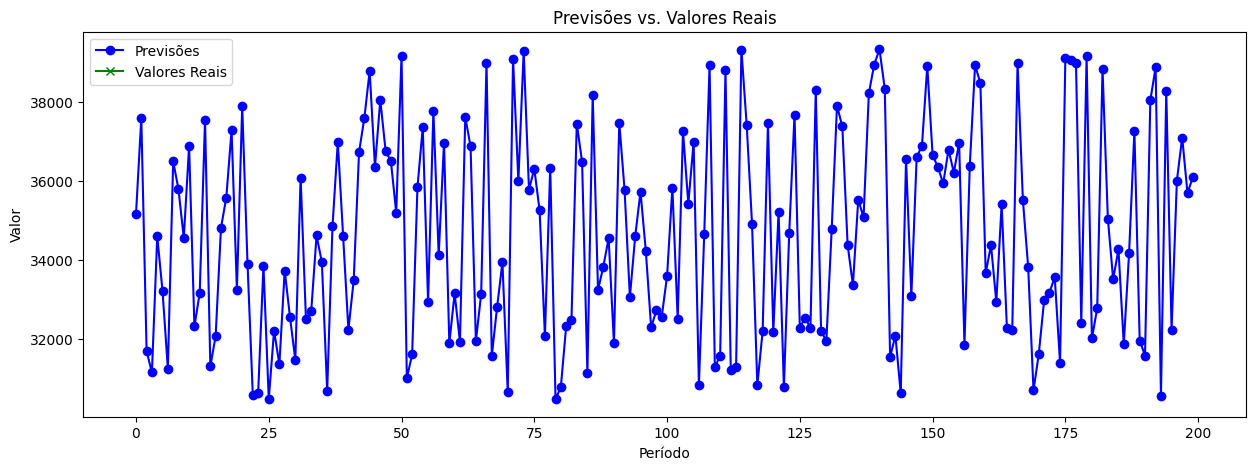

In [23]:
fig, axs = plt.subplots(figsize=(15, 5))

# Criar gráfico
plt.plot(dados_futuros['Encargo Futuro'], label='Previsões', color='blue', marker='o')
plt.plot(dados_futuros['Encargos'], label='Valores Reais', color='green', marker='x')

# Adicionar rótulos e legenda
plt.xlabel('Previsões')
plt.ylabel('Valores')
plt.legend()

# Exibir gráfico
plt.title('Previsões vs. Valores Reais')
plt.show()